In [1]:
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import pydicom

In [2]:
input_path = '/disk1/pytomography_paper_data/input'
output_path = '/disk1/pytomography_paper_data/output'

In [3]:
path_CT = os.path.join(input_path, 'spect_dicom_validation', 'CT')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
file_NM = os.path.join(input_path, 'spect_dicom_validation', 'projection_data.IMA')

In [4]:
object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=0)
photopeak= dicom.get_projections(file_NM, index_peak=0)
scatter = dicom.get_energy_window_scatter_estimate(file_NM, index_peak=0, index_lower=1, index_upper=2)
att_transform = SPECTAttenuationTransform(filepath=files_CT)
collimator_name = 'SY-ME'
energy_kev = 208
psf_meta = dicom.get_psfmeta_from_scanner_params(collimator_name, energy_kev, intrinsic_resolution=0.38)
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)
likelihood = PoissonLogLikelihood(system_matrix, photopeak, scatter)
reconstruction_algorithm = OSEM(likelihood)
reconstructed_object = reconstruction_algorithm(n_iters=4, n_subsets=8).cpu().numpy()[:,::-1]

Given photopeak energy 208.0 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2


In [5]:
ds_recon = pydicom.read_file(os.path.join(input_path, 'spect_dicom_validation', 'recon_siemens.IMA'))
recon_vendor = ds_recon.pixel_array / 96
recon_vendor = np.transpose(recon_vendor, (2,1,0))[:,::-1]
ds_recon_mim = pydicom.read_file(os.path.join(input_path, 'spect_dicom_validation', 'recon_MIM.dcm'))
recon_mim = ds_recon_mim.pixel_array / 96 * ds_recon_mim.RealWorldValueMappingSequence[0].RealWorldValueSlope
recon_mim = np.transpose(recon_mim, (2,1,0))[:,::-1]

In [6]:
l1, l2 = 47, 58
z = 61
xmin, xmax = 30, 100
ymin, ymax = 25, 95
def plot_differences(ax,l, uppery=None, lowery=None):
    distance = np.arange(128)*0.3
    line1 = recon_vendor[:,:,z][:,l]
    line2 = reconstructed_object[:,:,z][:,l]
    line3 = recon_mim[:,:,z][:,l]
    #line3 = line1 - line2
    ax.plot(distance, line1, marker='', ls='-', lw=1.5, color='red', label='Siemens')
    ax.plot(distance, line3, marker='', ls=':', lw=1.5, color='k', label='MIM')
    ax.plot(distance, line2, marker='', ls='--', lw=1.5, color='blue', label='PyTomography')
    ax.grid()
    if uppery: ax.set_ylim(top=uppery)
    if lowery: ax.set_ylim(bottom=lowery)
    ax.set_xlim(10,31)
    
def plot_object(ob, ax, add_text=False, mode='color'):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = 25
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 10
    im = ax.pcolormesh(ob[xmin:xmax,ymin:ymax,z].T, cmap=cmap, vmax=vmax, shading='gouraud')
    ax.axhline(l1-ymin, ls='--', color=tcol, lw=0.8)
    ax.axhline(l2-ymin, ls='--', color=tcol, lw=0.8)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if add_text:
        ax.text(5, l1-ymin+3, '1', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l2-ymin+3, '2', ha='center', va='center', color=tcol, size=13)
    return im

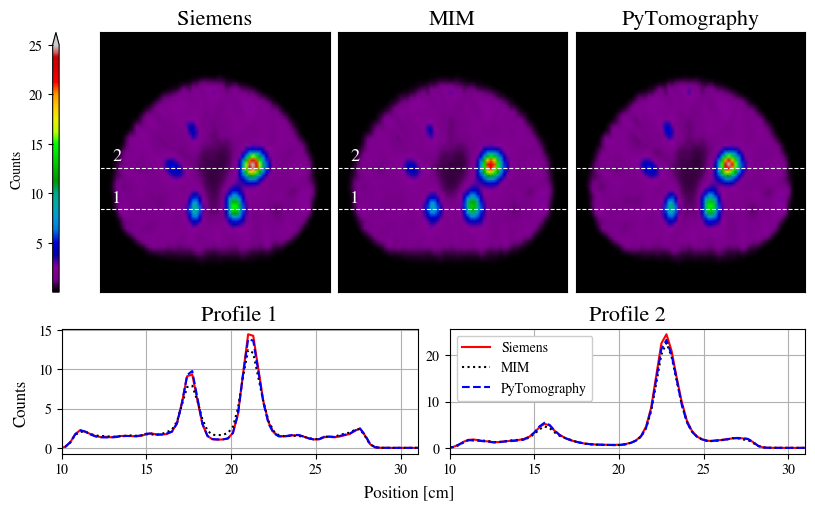

In [8]:
mode = 'color'
fig = plt.figure(constrained_layout=True, figsize=(8,5))
(subfig_l, subfig_r) = fig.subfigures(nrows=2, ncols=1, height_ratios=(1,0.7))
axes_l = subfig_l.subplots(nrows=1, ncols=3)
axes_l[0].set_title('Siemens', fontsize=16)
axes_l[1].set_title('MIM', fontsize=16)
axes_l[2].set_title('PyTomography', fontsize=16)
im = plot_object(recon_vendor, axes_l[0], add_text=True, mode=mode)
im = plot_object(recon_mim, axes_l[1], add_text=True, mode=mode)
im = plot_object(reconstructed_object, axes_l[2], mode=mode)
subfig_l.colorbar(im, ax=axes_l, location='left', label='Counts', extend='max', aspect=40)
axes_r = subfig_r.subplots(nrows=1, ncols=2, sharex=True)
plot_differences(axes_r[0],l1)
axes_r[0].set_title('Profile 1', fontsize=16)
plot_differences(axes_r[1],l2)
axes_r[1].legend(loc='upper left', facecolor='white', framealpha=1, frameon=True, fontsize=10)
axes_r[1].set_title('Profile 2', fontsize=16)
subfig_r.supxlabel('Position [cm]')
subfig_r.supylabel('Counts')
plt.savefig('figures/figure6.jpg', dpi=300, bbox_inches='tight')

In [9]:
import itk
nema_sphere_mask = np.transpose(itk.GetArrayFromImage(itk.imread(os.path.join(input_path, 'spect_dicom_validation', 'nema_masks.nrrd'))), (2,1,0))[:,::-1]

In [10]:
import numpy.linalg as npl
from scipy.ndimage import affine_transform
def _get_affine_spect_recon(filename):
    ds = pydicom.read_file(filename)
    Sx, Sy, Sz = ds.DetectorInformationSequence[0].ImagePositionPatient
    dx = dy = ds.PixelSpacing[0]
    dz = ds.PixelSpacing[1]
    Sz += 127*dz # location of upper voxel
    M = np.zeros((4, 4))
    M[0] = np.array([dx, 0, 0, Sx])
    M[1] = np.array([0, dy, 0, Sy])
    M[2] = np.array([0, 0, -dz, Sz])
    M[3] = np.array([0, 0, 0, 1])
    return M
def upsample_to_CT(recon):
    M_CT = dicom._get_affine_multifile(files_CT)
    # Use Siemens affine because it knows true bed position
    M_R= dicom._get_affine_spect_projections(file_NM)
    # Resample CT and convert to mu at 208keV and save
    M = npl.inv(M_R) @ M_CT
    return affine_transform(
        recon[:,::-1,::-1], M, output_shape=(512,512,76), order=1, mode='constant',
    )[:,::-1,::-1]

In [11]:
recon_upsample = upsample_to_CT(reconstructed_object)
recon_vendor_upsample = upsample_to_CT(recon_vendor)
recon_mim_upsample = upsample_to_CT(recon_mim)

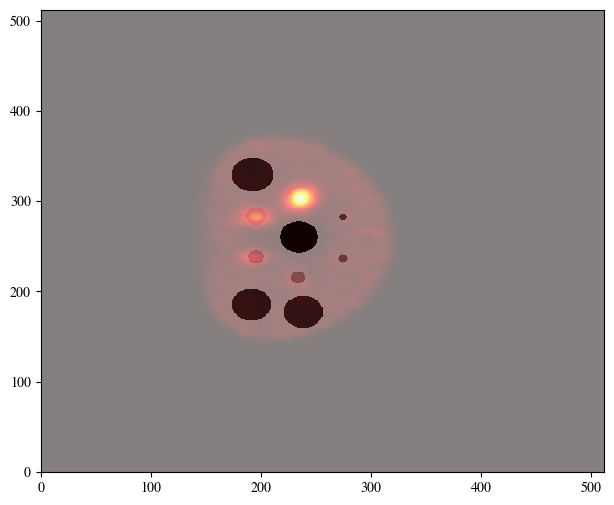

In [12]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(recon_upsample[:,:,25], cmap='hot')
plt.pcolormesh(nema_sphere_mask[:,:,26], cmap='Greys', alpha=0.5)

In [13]:
print(f'PyTomography: {recon_upsample[nema_sphere_mask==1].mean()}')
print(f'Siemens: {recon_vendor_upsample[nema_sphere_mask==1].mean()}')
print(f'MIM: {recon_mim_upsample[nema_sphere_mask==1].mean()}')

PyTomography: 13.488064765930176
Siemens: 14.071681568852417
MIM: 12.95884663345504


In [14]:
print(f'PyTomography: {recon_upsample[nema_sphere_mask==7].std()}')
print(f'Siemens: {recon_vendor_upsample[nema_sphere_mask==7].std()}')
print(f'MIM: {recon_mim_upsample[nema_sphere_mask==7].std()}')

PyTomography: 0.17892944812774658


Siemens: 0.19640148999334545
MIM: 0.1682435739003964


In [15]:
print(f'PyTomography: {recon_upsample[nema_sphere_mask==8].mean()}')
print(f'Siemens: {recon_vendor_upsample[nema_sphere_mask==8].mean()}')
print(f'MIM: {recon_mim_upsample[nema_sphere_mask==8].mean()}')

PyTomography: 0.6877192854881287
Siemens: 0.7317090706189479
MIM: 0.7040781626160902
